In [1]:
r"""
Self-supervised learning with Generalized Recorrupted-to-Recovered (GR2R) 
====================================================================================================

This example shows you how to train a reconstruction network for an denoising problem on a fully self-supervised way, i.e., using corrupted measurement data only.
"""

import os
import deepinv as dinv
from torch.utils.data import DataLoader
import torchvision
import torch
from pathlib import Path
from torchvision import transforms
from deepinv.optim.prior import PnP
from deepinv.utils.demo import load_dataset, load_degradation
import wandb
import argparse
from torch.utils.data import DataLoader, random_split
from deepinv.loss import PSNR, SSIM, Loss, SupLoss

from deepinv.training import train

/home/bemc/miniconda3/envs/deepinv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args:
    batch_size  = 20
    loss        = "gr2r_mse"
    epochs      = 10
    lr          = 1e-4
    noise       = None
    trial       = 0
    alpha       = 0.2

args = Args()

In [3]:
noise_distribution = "gamma" # can be "gaussian", "poisson" or "gamma"

if noise_distribution == "gaussian":
    args.noise = 0.1
    noise_model    = dinv.physics.GaussianNoise(args.noise)
    r2r_loss       = dinv.loss.R2RLoss(sigma=args.noise, alpha=args.alpha)

elif noise_distribution == "poisson":
    args.noise = 0.1
    noise_model    = dinv.physics.PoissonNoise(args.noise)
    r2r_loss       = dinv.loss.R2RPoissonLoss(gain=args.noise, p=args.alpha)

elif noise_distribution == "gamma":
    args.noise = 5.0
    noise_model    = dinv.physics.GammaNoise(args.noise)
    r2r_loss       = dinv.loss.R2RGammaLoss(l=args.noise, alpha=args.alpha)


# print actual setup
print("Selecting noise model: ", noise_distribution)
print("Noise level: ", args.noise)
print("Alpha: ", args.alpha)

Selecting noise model:  gamma
Noise level:  5.0
Alpha:  0.2


In [4]:
# ---------------------------------------------------------------
# Setup paths for data loading and results.
# ---------------------------------------------------------------

BASE_DIR = Path(".")
# PROJECT_NAME = "denoising-poisson"
PROJECT_NAME = f"denoising-{noise_distribution}"
ORIGINAL_DATA_DIR =  Path("./data")
DATA_DIR = ORIGINAL_DATA_DIR / "measurements"
RESULTS_DIR = BASE_DIR / "results"
DEG_DIR = BASE_DIR / "degradations"
CKPT_DIR = BASE_DIR / "ckpts" / PROJECT_NAME
verbose   = True
wandb_vis = False

# Set the global random seed from pytorch to ensure reproducibility of the example.
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

Selected GPU 0 with 22042 MB free memory 


In [5]:
# print  all the arguments
trial_id = args.trial
torch.manual_seed(trial_id)

run_name = f"{args.loss}-{args.noise}"

wandb_setup = {
    "project": PROJECT_NAME,
    "config": args,
    "name": run_name,
}

operation = f"Denoising_{args.noise}"
train_dataset_name = "div2k"

In [6]:
# # ----------------------------------------------------------------------------------
# Generate a dataset of knee images and load it.
# ----------------------------------------------------------------------------------

# defined physics
physics = dinv.physics.Denoising(noise_model=noise_model)

# Use parallel dataloader if using a GPU to fasten training,
# otherwise, as all computes are on CPU, use synchronous data loading.
num_workers     = 0 if torch.cuda.is_available() else 0
n_images_max    = 5000 # if is greater that train set, image may will duplicated

my_dataset_name = f"div2k_{noise_distribution}"
measurement_dir = DATA_DIR / train_dataset_name / operation

# check if the dataset is already generated
# if not, generate it


img_size = 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop((img_size, img_size))
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((img_size, img_size))
])

div2k_train_path    = ORIGINAL_DATA_DIR / "DIV2K_train_HR.zip"
div2k_test_path     = ORIGINAL_DATA_DIR / "DIV2K_valid_HR.zip"

download_train  = os.path.exists(div2k_train_path)
download_test   = os.path.exists(div2k_test_path)

train_dataset    =  dinv.datasets.DIV2K(root=ORIGINAL_DATA_DIR, mode="train", transform=transform, download=download_train)
test_dataset     =  dinv.datasets.DIV2K(root=ORIGINAL_DATA_DIR, mode="val", transform=test_transform, download=download_test)

if not os.path.exists(measurement_dir / f"{my_dataset_name}0.h5"):
    deepinv_datasets_path = dinv.datasets.generate_dataset(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        physics=physics,
        device=device,
        save_dir=measurement_dir,
        train_datapoints=n_images_max,
        num_workers=num_workers,
        dataset_filename=str(my_dataset_name),
    )
else:      
    deepinv_datasets_path = measurement_dir / f"{my_dataset_name}0.h5"

train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)

Dataset has been saved in data/measurements/div2k/Denoising_5.0


In [7]:
# Set up the reconstruction network
# ---------------------------------------------------------------
#
# As a reconstruction network, we use an unrolled network (half-quadratic splitting)
# with a trainable denoising prior based on the DnCNN architecture.

n_channels = 3  


model = dinv.models.DRUNet( in_channels=n_channels,
                            out_channels=n_channels,
                            pretrained=None,
                            nc=[16, 32, 64, 128],
                            train=True,
                            last_act='relu').to(device)

# print number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


# Set up the training parameters
# --------------------------------------------

epochs        = args.epochs
learning_rate = args.lr
batch_size    = args.batch_size # if torch.cuda.is_available() else 1
noise_level   = args.noise


if args.loss == "sup":   # SUPERVISED LOSS
    loss = dinv.loss.SupLoss()

elif args.loss == "gr2r_mse": # GENERALIZED R2R LOSS - MSE VARIANT
    loss     = [ r2r_loss ]
    model    = r2r_loss.adapt_model(model, MC_samples=10)

elif args.loss == "neigh": # NEIGHBORHOOD LOSS

    neigh_loss = dinv.loss.Neighbor2Neighbor()
    loss = [ neigh_loss ]


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(epochs * 0.8) + 1)


Number of parameters: 2040816


The model has 2040816 trainable parameters


Eval epoch 10:  99%|█████████████████████████████████████████████████████████████████████████▎| 99/100 [00:04<00:00, 18.58it/s, PSNR=23.7, SSIM=0.675]

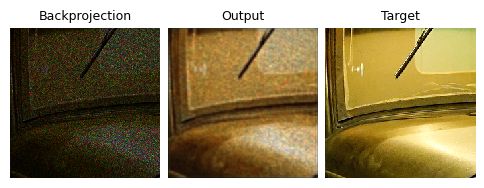

Train epoch 10: 100%|███████████████████████████████████████████████████████▊| 249/250 [00:33<00:00,  7.50it/s, TotalLoss=0.27, PSNR=24.6, SSIM=0.667]

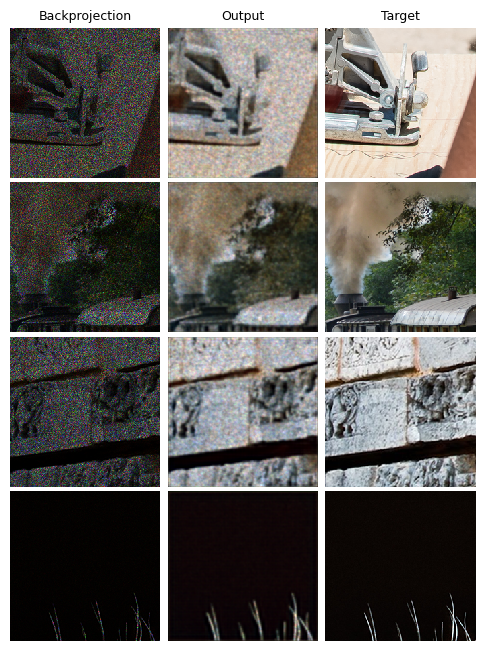

Train epoch 10: 100%|████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.48it/s, TotalLoss=0.27, PSNR=24.6, SSIM=0.667]


EVALUATING THE MODEL ON THE TEST DATASET


Test :   0%|                                                                                                                  | 0/100 [00:00<?, ?it/s]

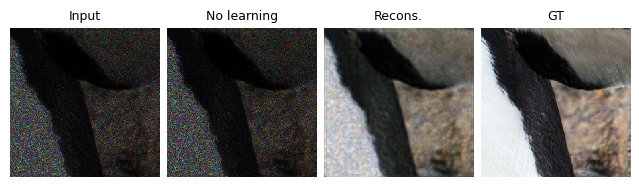

Test : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.92it/s]

Test PSNR: No learning rec.: 13.798+-3.316 | Model: 23.734+-3.223. 
Test SSIM: No learning rec.: 0.388+-0.185 | Model: 0.675+-0.102. 


(23.7338710975647, 0.6749750123524576)

In [8]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, num_workers=num_workers, shuffle=False
)

trainer = dinv.Trainer(
    metrics=[ PSNR(), SSIM() ],
    model=model,
    physics=physics,
    epochs=epochs,
    scheduler=scheduler,
    losses=loss,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    plot_images=True,
    device=device,
    save_path=Path(CKPT_DIR / f"noise={args.noise}"  / args.loss ),
    verbose=verbose,
    wandb_vis=False,
    show_progress_bar=True,
    ckp_interval=1,
    wandb_setup=None,
    eval_dataloader=test_dataloader,
    freq_plot=10,
)

model = trainer.train()

# Evaluate the model on the test dataset
print("EVALUATING THE MODEL ON THE TEST DATASET")
trainer.test(test_dataloader)